In [ ]:
imported_path = '/content/drive/Shareddrives/Profundos/DeepLearning_2021/FinalProject/deppBuenardo/trained_models/20_Layer/model_epoch_24.sav'

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified

Number of Wrongly Classified Obects per Class: 
{'Airplane': 563, 'Automobile': 391, 'Bird': 880, 'Cat': 863, 'Deer': 698, 'Dog': 369, 'Frog': 476, 'Horse': 546, 'Ship': 499, 'Truck': 554} 

\Relative Wrongly Classified Obects per Class: 
{'Airplane': 0.0964206199691728, 'Automobile': 0.066963521150882, 'Bird': 0.15071073814009248, 'Cat': 0.14779928069874979, 'Deer': 0.11954101729748244, 'Dog': 0.06319575269737969, 'Frog': 0.08152080835759548, 'Horse': 0.0935091625278301, 'Ship': 0.08545983901352971, 'Truck': 0.0948792601472855} 

Checkpoint saved
Epoch 0, Train Accuracy: 0.32189998030662537 , TrainLoss: 1.768718957901001 , Test Accuracy: 0.4161

Number of Wrongly Classified Obects per Class: 
{'Airplane': 618, 'Automobile': 439, 'Bird': 753, 'Cat': 809, 'Deer': 415, 'Dog': 632, 'Frog': 223, 'Horse': 481, 'Ship': 272, 'Truck': 235} 

\Relative Wrongly Classified Obects per Class: 
{'Airplane': 0.1267172442075046, 'Automobile': 0.09001435308591348,

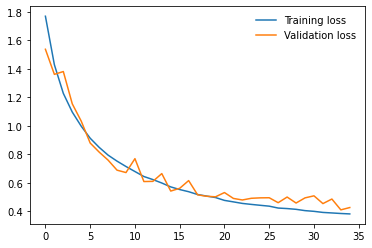

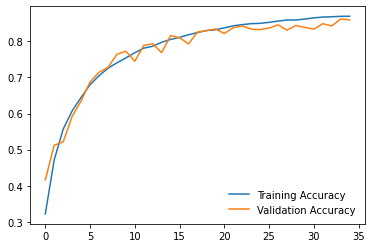

In [ ]:
#Import needed packages
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import joblib

train_losses, test_losses = [], []
train_accuracy, test_accuracy = [], []
imported_path = '/content/drive/Shareddrives/Profundos/DeepLearning_2021/FinalProject/deppBuenardo/trained_models/20_Layer/model_epoch_24.sav'
output_path = '/content/drive/Shareddrives/Profundos/DeepLearning_2021/FinalProject/deppBuenardo/trained_models/20_Layer/' 

class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class SimpleNet(nn.Module):
    def __init__(self,num_classes=10):
        super(SimpleNet,self).__init__()

        #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)
        self.plusunit1 = Unit(in_channels=32, out_channels=32)
        self.plusunit2 = Unit(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)
        self.plusunit3 = Unit(in_channels=64, out_channels=64)
        self.plusunit4 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)
        self.plusunit5 = Unit(in_channels=128, out_channels=128)
        self.plusunit6 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2) 

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.plusunit1, self.plusunit2, self.pool1, self.unit4, self.unit5, self.unit6,
                                 self.unit7, self.plusunit3, self.plusunit4, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.plusunit5, self.plusunit6, self.pool3, 
                                 self.unit12, self.unit13, self.unit14, self.avgpool)

        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)
        return output

#Define transformations for the training set, flip the images randomly, crop out and apply mean and std normalization
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

#Load the training set
train_set = CIFAR10(root="./data",train=True,transform=train_transformations,download=True)

#Create a loder for the training set
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)


#Define transformations for the test set
test_transformations = transforms.Compose([
   transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

])

#Load the test set, note that train is set to False
test_set = CIFAR10(root="./data",train=False,transform=test_transformations,download=True)

#Create a loder for the test set, note that both shuffle is set to false for the test loader
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=4)

#Check if gpu support is available
cuda_avail = torch.cuda.is_available()

#Create model ch
model = SimpleNet(num_classes=10)


if cuda_avail:
    model.cuda()

optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()


def save_models(epoch):
    filename = output_path + "model_epoch_{}.sav".format(epoch)
    joblib.dump(model, filename)
    print("Checkpoint saved")

def test():
    model.eval()
    test_acc = 0.0
    test_loss = 0.0
    errors = {
      "Airplane":0, 
      "Automobile":0,
      "Bird":0,
      "Cat":0,
      "Deer":0,
      "Dog":0,
      "Frog":0,
      "Horse":0,
      "Ship":0,
      "Truck":0,
      }
    lable_names=["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
    for i, (images, labels) in enumerate(test_loader):
        if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

        #Predict classes using images from the test set
        outputs = model(images)
        loss = loss_fn(outputs,labels)
        test_loss += loss.cpu().data * images.size(0)
        _,prediction = torch.max(outputs.data, 1)
        prediction = prediction.cpu().numpy()
        labels = labels.data.cpu().numpy()

        for k in range(len(prediction)):
          if prediction[k]==labels.data[k]:
            test_acc +=1
          else:
            errors[lable_names[labels.data[k]]]+=1
        

    test_acc = test_acc / 10000
    test_loss = test_loss / 10000
    test_accuracy.append(test_acc)
    test_losses.append(test_loss)

    total_errors=0

    for key in errors:
      total_errors+=errors[key]

    relative_errors = {}
    for key in errors:
      relative_errors[key] = errors[key]/total_errors

    print("\nNumber of Wrongly Classified Obects per Class: ")
    print(errors,"\n")

    print("\Relative Wrongly Classified Obects per Class: ")
    print(relative_errors,"\n")
    return test_acc

def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()

        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            #Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            #Clear all accumulated gradients
            optimizer.zero_grad()
            #Predict classes using images from the test set
            outputs = model(images)
            #Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs,labels)
            #Backpropagate the loss
            loss.backward()

            #Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc += torch.sum(prediction == labels.data)


        #Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / 50000
        train_loss = train_loss / 50000
        train_accuracy.append(train_acc)
        train_losses.append(train_loss)

        #Evaluate on the test set
        test_acc = test()

        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc


        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))

    


if __name__ == "__main__":
    train(35)
    
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(test_accuracy, label='Validation Accuracy')
    plt.legend(frameon=False)
    plt.show()



In [ ]:
loaded_model = joblib.load(imported_path)
loaded_model.eval()

test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):
  
    if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

    #Predict classes using images from the test set
    outputs = loaded_model(images)
    _,prediction = torch.max(outputs.data, 1)
    prediction = prediction.cpu().numpy()
    
    for k in range(len(prediction)):
      if prediction[k]==labels.data[k]:

        test_acc +=1

#Compute the average acc and loss over all 10000 test images
test_acc = test_acc / 10000
print(test_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8534


In [ ]:
# añadir: plt.plot(train_losses, label='Training loss')
#         plt.plot(test_losses, label='Validation loss')
#         plt.legend(frameon=False)
#         plt.show()
